## "Convex Optimizations Course"

## Implementation of the algorithm of Robust PCA described in the article "Robust Principal Component Analysis" by Emmanuel J. Cand'es, Xiaodong Li, Yi Ma, and John Wright.

### Implementation created by students: Abramov Semen, Koposov Denis
### Skoltech, 14 December, 2018

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

In [2]:
class RobustPCA:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.sum(np.abs(self.D)))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        i = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1e-7 * np.linalg.norm(self.D, 'fro')

        while (err > _tol) and i < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = np.linalg.norm(self.D - Lk - Sk, 'fro')
            i += 1
            
            if (i % iter_print) == 0 or i == 1 or i > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(i, err))

        self.L = Lk
        self.S = Sk
        
        return Lk, Sk

### Background separation

In [3]:
def load_sequence(path, start, stop):
    
    files = os.listdir(path)
    files.sort()
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame)
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame)
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size
    
def display_result(M, L, S, n_frames):
    n = M.shape[2]
    lst = np.random.choice(range(n), n_frames)
    
    for i in range(len(lst)):
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(M[:,:,lst[i]], cmap='gray')
        if i == 0:
            plt.title('M', fontsize=18)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(L[:,:,lst[i]], cmap='gray')
        if i == 0:
            plt.title('L', fontsize=18)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(S[:,:,lst[i]], cmap='gray')
        if i == 0:
            plt.title('S', fontsize=18)
        plt.axis('off')

### Datasets were downloaded from: https://www.microsoft.com/en-us/download/confirmation.aspx?id=54651

In [4]:
videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 200
M, frame_size = load_sequence(videos[0], start, stop)

In [5]:
%%time

rpca = RobustPCA(M)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 2541.2583893871088
iteration: 100, error: 9.354459725333344
iteration: 200, error: 0.9455799092857725
iteration: 300, error: 0.23498155686227346
iteration: 400, error: 0.09962936421037792
iteration: 500, error: 0.05804546028146491
iteration: 600, error: 0.038712654943814276
iteration: 700, error: 0.027719321542675767
iteration: 800, error: 0.021183138707988346
CPU times: user 24min 40s, sys: 2min 10s, total: 26min 51s
Wall time: 7min 14s


In [6]:
print ("Matrix M size: ", M.shape)
print ("Matrix L rank: ", np.linalg.matrix_rank(L))
print ("Matrix S rank: ", np.linalg.matrix_rank(S))

Matrix M size:  (19200, 200)
Matrix L rank:  84
Matrix S rank:  200


In [7]:
M_frames_video = M.reshape(*frame_size, -1)
S_frames_video = S.reshape(*frame_size, -1)
L_frames_video = L.reshape(*frame_size, -1)

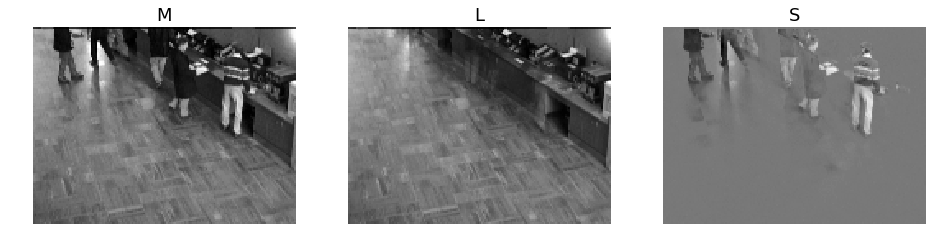

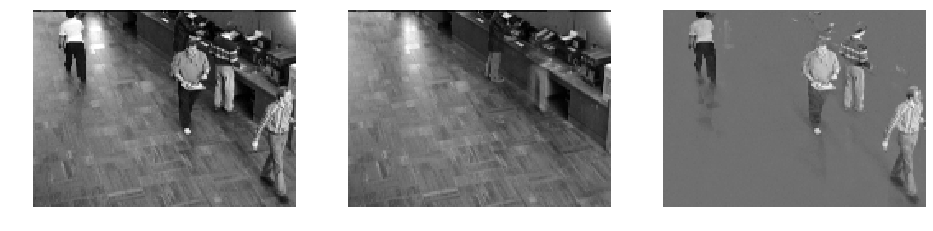

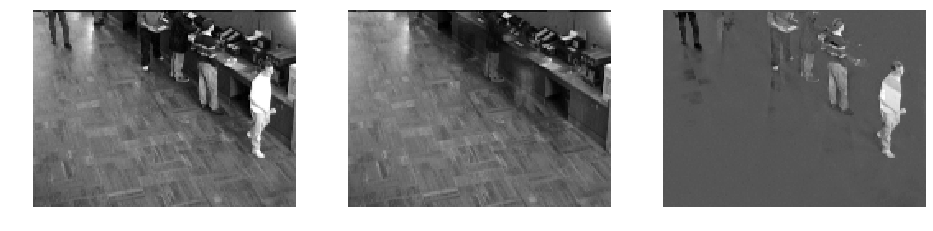

In [8]:
display_result(M_frames_video,
               L_frames_video,
               S_frames_video, 3)

### Datasets were downloaded from: http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html

In [9]:
path = "./CroppedYale/yaleB02"

def load_sequence(path):
    files = os.listdir(path)[-58:]
    frame = Image.open(os.path.join(path, files[25]))

    frame = np.array(frame)
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, len(files)))
    
    for i in range(len(files)):
        frame = Image.open(os.path.join(path, files[i]))
        frame = np.array(frame)
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

In [10]:
M, frame_size = load_sequence(path)

In [11]:
%%time

rpca = RobustPCA(M)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 1227.4315400018168
iteration: 100, error: 9.544571947114262
iteration: 200, error: 1.2778667017822996
iteration: 300, error: 0.23505946650724485
iteration: 400, error: 0.06300848347046266
iteration: 500, error: 0.024496071572279596
iteration: 587, error: 0.013298100541154698
CPU times: user 8min 30s, sys: 53.9 s, total: 9min 24s
Wall time: 2min 23s


In [12]:
print ("Matrix M size: ", M.shape)
print ("Matrix L rank: ", np.linalg.matrix_rank(L))
print ("Matrix S rank: ", np.linalg.matrix_rank(S))

Matrix M size:  (32256, 58)
Matrix L rank:  30
Matrix S rank:  58


In [13]:
M_frames_faces = M.reshape(*frame_size, -1)
S_frames_faces = S.reshape(*frame_size, -1)
L_frames_faces = L.reshape(*frame_size, -1)

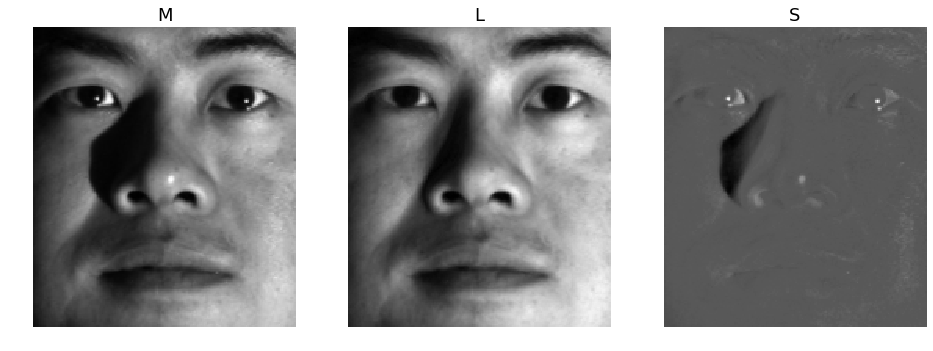

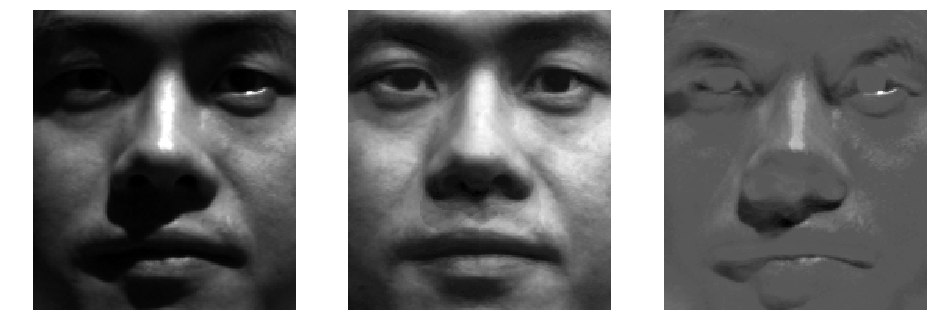

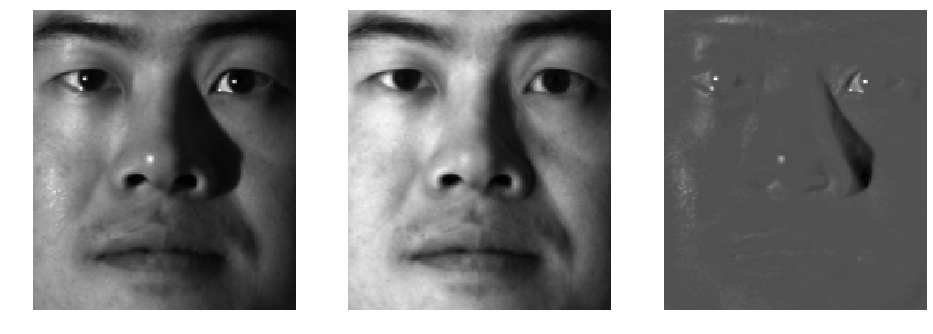

In [14]:
display_result(M_frames_faces,
               L_frames_faces,
               S_frames_faces, 3)